## Creating baseline DNN Model and evaluating accuracy on MNSIT Test dataset

In [267]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [268]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [269]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [78]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [282]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [283]:
model = DNN()

In [284]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [286]:
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch_idx+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

In [287]:
train(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch [1/5], Step [100/938], Loss: 0.4593
Epoch [1/5], Step [200/938], Loss: 0.3650
Epoch [1/5], Step [300/938], Loss: 0.3550
Epoch [1/5], Step [400/938], Loss: 0.2369
Epoch [1/5], Step [500/938], Loss: 0.2742
Epoch [1/5], Step [600/938], Loss: 0.1259
Epoch [1/5], Step [700/938], Loss: 0.1965
Epoch [1/5], Step [800/938], Loss: 0.2488
Epoch [1/5], Step [900/938], Loss: 0.2820
Epoch [2/5], Step [100/938], Loss: 0.2608
Epoch [2/5], Step [200/938], Loss: 0.1703
Epoch [2/5], Step [300/938], Loss: 0.1110
Epoch [2/5], Step [400/938], Loss: 0.1189
Epoch [2/5], Step [500/938], Loss: 0.1708
Epoch [2/5], Step [600/938], Loss: 0.0441
Epoch [2/5], Step [700/938], Loss: 0.1373
Epoch [2/5], Step [800/938], Loss: 0.1160
Epoch [2/5], Step [900/938], Loss: 0.0406
Epoch [3/5], Step [100/938], Loss: 0.0931
Epoch [3/5], Step [200/938], Loss: 0.0530
Epoch [3/5], Step [300/938], Loss: 0.0117
Epoch [3/5], Step [400/938], Loss: 0.0456
Epoch [3/5], Step [500/938], Loss: 0.1499
Epoch [3/5], Step [600/938], Loss:

In [288]:
def evaluate(model, test_dataset):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, target in test_dataset:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total+=1
            correct+= (predicted==target)

        accuracy = 100 * correct.item() / float(total)
        print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

In [289]:
evaluate(model, test_dataset)

Accuracy of the model on the test images: 96.62%


## Helper function to plot images

In [290]:
def plot_images(images, labels):
    plt.figure(figsize=(5, 10))

    for i, (orig, perturbed) in enumerate(images):
        orig = orig.squeeze().detach().cpu().numpy()
        perturbed = perturbed.squeeze().detach().cpu().numpy()
        i_label, a_label = labels[i]

        # Plot original image
        plt.subplot(len(images), 2, 2*i+1)
        plt.imshow(orig, cmap="gray")
        plt.axis('off')
        # Place a text label on the original image
        plt.text(5, 5, f"{i_label}", color="green", fontsize=20)
        plt.title("Original")

        # Plot perturbed image
        plt.subplot(len(images), 2, 2*i+2)
        plt.imshow(perturbed, cmap="gray")
        plt.axis('off')
        # Place a text label on the perturbed image
        plt.text(5, 5, f"{a_label}", color="red", fontsize=20)
        plt.title("Pertubed")

    plt.tight_layout()
    plt.show()

## FGSM based untargeted attacks

In [291]:
import torch
import torch.nn.functional as F

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def test_fgsm(model, device, test_dataset, epsilon):
    model.eval()
    adv_examples = []
    img_counter = 0
    total_correct = 0
    total_misclassified = 0
    labels = []

    for data, target in test_dataset:
        data, target = data.unsqueeze(0).to(device), torch.tensor([target]).to(device)
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        total_correct += 1
        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()

        if data.grad is not None:
            data_grad = data.grad.data
            perturbed_data = fgsm_attack(data, epsilon, data_grad)

            output = model(perturbed_data)
            final_pred = output.max(1, keepdim=True)[1]

            if final_pred.item() != target.item():
                total_misclassified += 1
                if img_counter < 2:
                    adv_examples.append((data.squeeze().detach().cpu(), perturbed_data.squeeze().detach().cpu()))
                    labels.append((init_pred.item(), final_pred.item()))
                    img_counter += 1

    final_acc = total_misclassified / float(total_correct)
    print(f"Epsilon: {epsilon}\tFraction Successful Attacks = {total_misclassified} / {total_correct} = {final_acc}")

    return final_acc, adv_examples, labels

Epsilon: 0.1	Fraction Successful Attacks = 1148 / 9662 = 0.11881598012833781


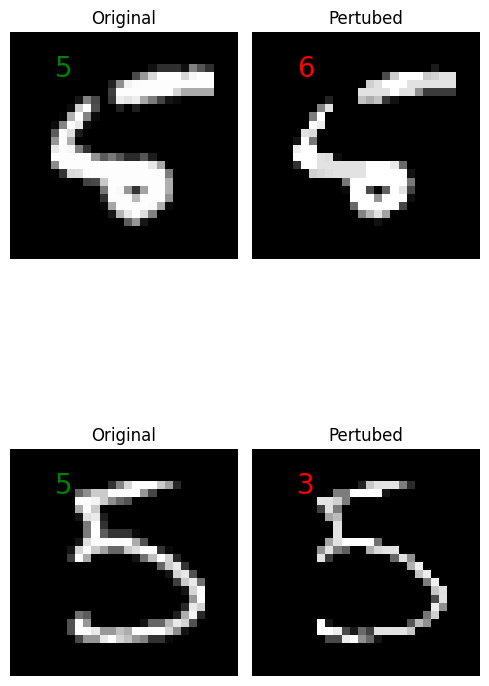

Epsilon: 0.2	Fraction Successful Attacks = 2048 / 9662 = 0.2119643966052577


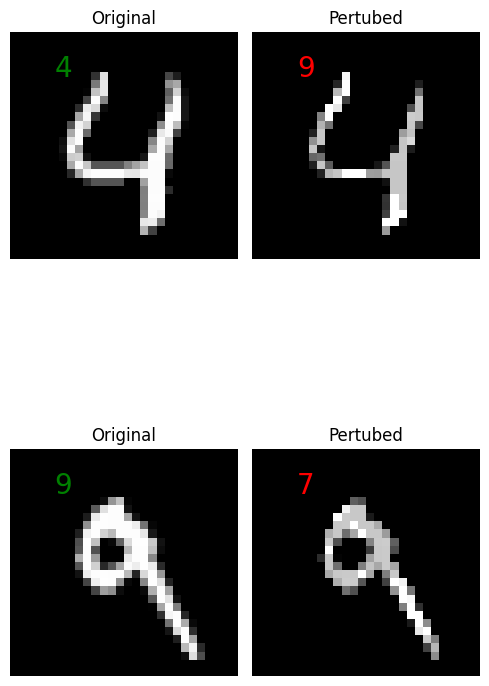

Epsilon: 0.25	Fraction Successful Attacks = 2665 / 9662 = 0.2758228110122128


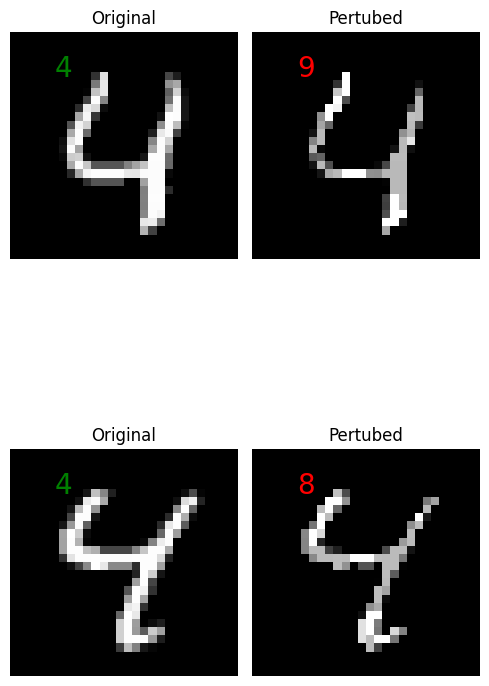

Epsilon: 0.3	Fraction Successful Attacks = 3292 / 9662 = 0.340716207824467


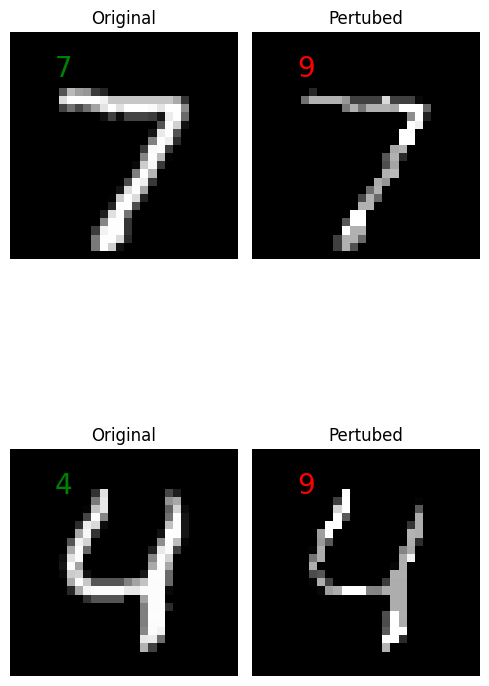

Epsilon: 0.4	Fraction Successful Attacks = 4611 / 9662 = 0.4772303870834196


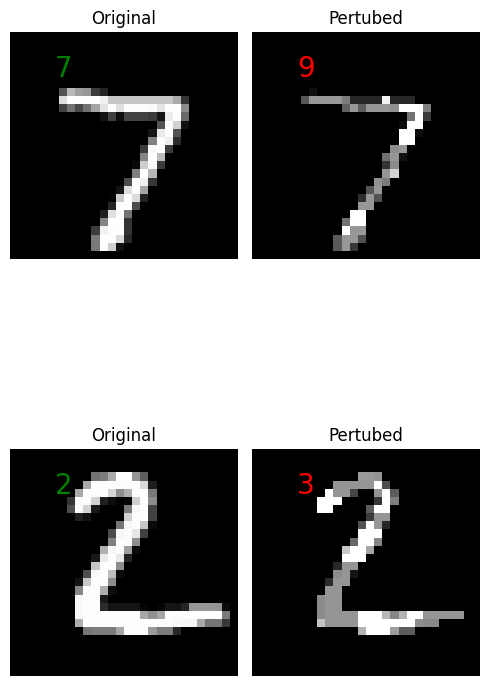

Epsilon: 0.5	Fraction Successful Attacks = 5868 / 9662 = 0.6073276754295177


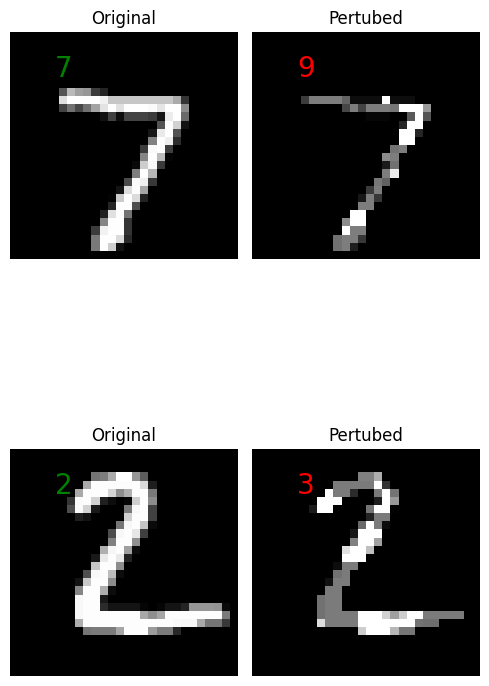

In [292]:
epsilons = [.1, .2, .25, .3, .4, .5]

# Run test for each epsilon
for eps in epsilons:
    acc, im, labels = test_fgsm(model, "cpu", test_dataset, eps)
    plot_images(im, labels)

## FGSM based targeted attacks

In [293]:
def fgsm_targeted_attack(image, epsilon, data_grad):
    perturbed_image = image - epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [248]:
def test_targeted_fgsm(model, device, test_dataset, epsilon):
    correct = 0
    img_counter = 0  # Counter for images
    images = []
    real_false_labels = []
    custom_images = []
    labels = []
    total_successful_attacks = 0

    for data, target in test_dataset:
        data, target = data.unsqueeze(0).to(device), torch.tensor([target]).to(device)
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        original_label = target[0]

        if init_pred.item() != original_label.item():
            continue

        target_label = (original_label + 1) % 10  # Target label for the attack

        output = model(data)

        correct += 1
        L = nn.CrossEntropyLoss()
        loss = L(output, torch.tensor([target_label]).to(device))
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        # Call targeted FGSM Attack
        perturbed_data = fgsm_targeted_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == target_label.item():
            total_successful_attacks += 1
            if img_counter < 2:
                images.append((data.squeeze(0), perturbed_data.squeeze(0)))
                labels.append((init_pred.item(), target_label.item()))
                img_counter += 1
            real_false_labels.append(original_label.item())
            custom_images.append(perturbed_data.squeeze(0).detach())

    attack_success_rate = total_successful_attacks / float(correct)
    print(f"Epsilon: {epsilon}\tAttack Success Rate = {total_successful_attacks}/{correct} = {attack_success_rate}")

    return attack_success_rate, images, labels, custom_images, real_false_labels

Epsilon: 0.1	Attack Success Rate = 172/9662 = 0.01780169737114469


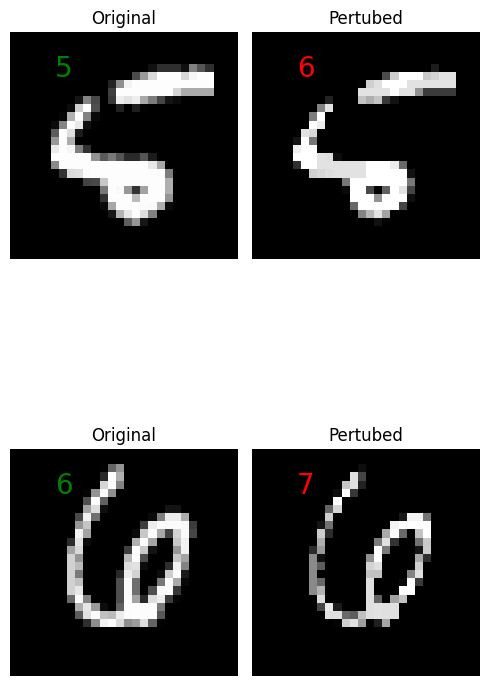

Epsilon: 0.2	Attack Success Rate = 423/9662 = 0.04377975574415235


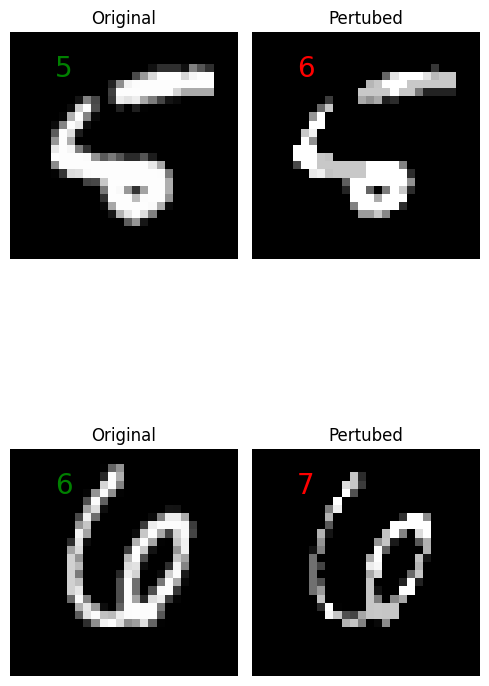

Epsilon: 0.3	Attack Success Rate = 821/9662 = 0.08497205547505693


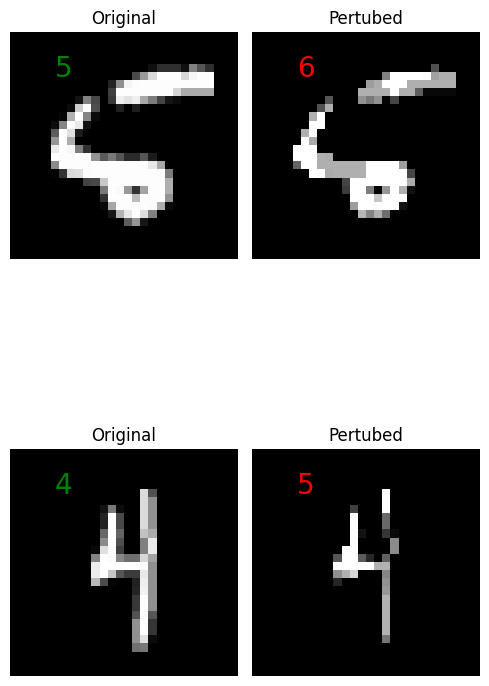

Epsilon: 0.4	Attack Success Rate = 1259/9662 = 0.13030428482715795


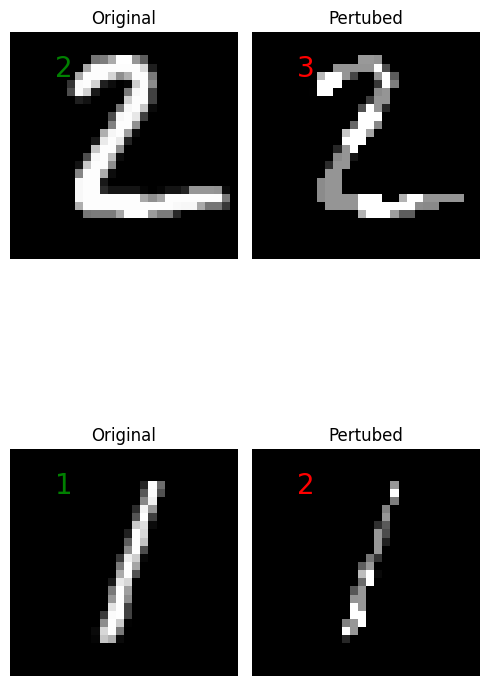

Epsilon: 0.5	Attack Success Rate = 1683/9662 = 0.1741875388118402


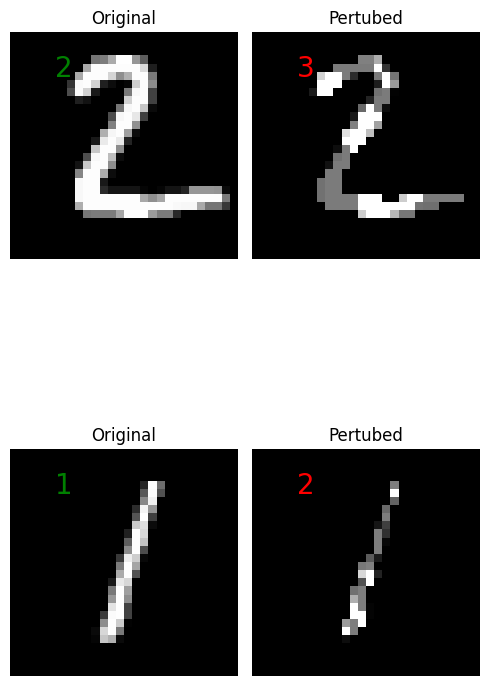

In [294]:
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = []

# Run test for each epsilon
for eps in epsilons:
    acc, im, labels, custom_images, real_false_labels = test_targeted_fgsm(model, "cpu", test_dataset, eps)
    accuracies.append(acc)
    plot_images(im, labels)

## Entering custom images into training dataset

In [295]:
acc, im, labels, custom_images, real_false_labels = test_targeted_fgsm(model, "cpu", test_dataset, 125/255)

Epsilon: 0.49019607843137253	Attack Success Rate = 1642/9662 = 0.16994411095011386


In [297]:
from torch.utils.data import ConcatDataset, DataLoader, TensorDataset
custom_labels_tensor = torch.tensor(real_false_labels)
custom_dataset = TensorDataset(torch.stack(custom_images), custom_labels_tensor)
combined_dataset = ConcatDataset([train_dataset, custom_dataset])
print(custom_images[0].shape)

torch.Size([1, 28, 28])


In [298]:
custom_loader = DataLoader(custom_dataset, batch_size=64, shuffle=True)
for images, labels in custom_loader:
    assert isinstance(images, torch.Tensor)
    assert isinstance(labels, torch.Tensor)
    print(f"Custom batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
    break

Custom batch - Images shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])


In [299]:
mnist_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
for images, labels in mnist_loader:
    assert isinstance(images, torch.Tensor)
    assert isinstance(labels, torch.Tensor)
    print(f"MNIST batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
    break

MNIST batch - Images shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])


In [300]:
def custom_collate(batch):
    images = [item[0] for item in batch]  # Extract images
    labels = [item[1] for item in batch]  # Extract labels

    images = torch.stack(images)  # Stack images
    labels = torch.tensor(labels)  # Convert labels list to tensor

    return images, labels

combined_train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, collate_fn=custom_collate)
for images, labels in combined_train_loader:
    print(f"Combined batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
    break

Combined batch - Images shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])


## New Adversarially Trained Model

In [303]:
adversarial_trained_model = DNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(adversarial_trained_model.parameters(), lr=0.001)
train(adversarial_trained_model, combined_train_loader, criterion, optimizer, num_epochs=5)

Epoch [1/5], Step [100/964], Loss: 0.5256
Epoch [1/5], Step [200/964], Loss: 0.4135
Epoch [1/5], Step [300/964], Loss: 0.1428
Epoch [1/5], Step [400/964], Loss: 0.1580
Epoch [1/5], Step [500/964], Loss: 0.1007
Epoch [1/5], Step [600/964], Loss: 0.3251
Epoch [1/5], Step [700/964], Loss: 0.1715
Epoch [1/5], Step [800/964], Loss: 0.2078
Epoch [1/5], Step [900/964], Loss: 0.1715
Epoch [2/5], Step [100/964], Loss: 0.2023
Epoch [2/5], Step [200/964], Loss: 0.2652
Epoch [2/5], Step [300/964], Loss: 0.1907
Epoch [2/5], Step [400/964], Loss: 0.0736
Epoch [2/5], Step [500/964], Loss: 0.1785
Epoch [2/5], Step [600/964], Loss: 0.2044
Epoch [2/5], Step [700/964], Loss: 0.0342
Epoch [2/5], Step [800/964], Loss: 0.2422
Epoch [2/5], Step [900/964], Loss: 0.2050
Epoch [3/5], Step [100/964], Loss: 0.1650
Epoch [3/5], Step [200/964], Loss: 0.0592
Epoch [3/5], Step [300/964], Loss: 0.1750
Epoch [3/5], Step [400/964], Loss: 0.0670
Epoch [3/5], Step [500/964], Loss: 0.1027
Epoch [3/5], Step [600/964], Loss:

In [304]:
epsilons = [.1, .2, .25, .3, .4, .5]
# Run test for each epsilon
for eps in epsilons:
    acc, im, labels = test_fgsm(adversarial_trained_model, "cpu", test_dataset, eps)

Epsilon: 0.1	Fraction Successful Attacks = 4415 / 9742 = 0.4531923629644837
Epsilon: 0.2	Fraction Successful Attacks = 4677 / 9742 = 0.4800862245945391
Epsilon: 0.25	Fraction Successful Attacks = 4851 / 9742 = 0.49794703346335456
Epsilon: 0.3	Fraction Successful Attacks = 5075 / 9742 = 0.5209402586737836
Epsilon: 0.4	Fraction Successful Attacks = 5558 / 9742 = 0.5705194005337713
Epsilon: 0.5	Fraction Successful Attacks = 6110 / 9742 = 0.6271812769451858
